# Working ipynb for explainability in machine learning 

- main goal is to delineate model explainability between Shap, Lime and GAM
- This will act as a shell file on the Austrailian Credit Approval Data until Cap One data is readily available

## Model Building

Imports. Clean up later

In [1]:
from __future__ import print_function
from helpful_util import *
from heaton_utils import *

import seaborn as sns
import pandas_profiling
from pylab import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

import sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

#!pip install livelossplot
from livelossplot import PlotLossesKeras
from tensorflow.python.client import device_lib
from keras.losses import binary_crossentropy


import os
import sys
import glob
#pip install counter
import pickle

import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.utils import layer_utils
from keras import backend as K
from keras.engine.topology import get_source_inputs
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.optimizers import SGD, adam, adamax, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, ReLU, ELU
from keras.losses import binary_crossentropy
from keras.utils import multi_gpu_model

device_lib.list_local_devices() #See available devices. If Running a Keras model, session to GPU



Using TensorFlow backend.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14049916022137916143, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6590074061
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 56638220266009777
 physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 6700198133
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1654212337970855424
 physical_device_desc: "device: 1, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1"]

In [6]:
#files, main_dir = list_dir()
#main_dir
#list_dir()[1] #List contents of working Dir

#Clean Data
#Used for Australian Credit Data
#df = load_data(path='data', drop_outliers= False) #Only remove outliers on non-discrete features

In [15]:
df = load_data_UCI(clean = True)

df

,workclass_num,education.num,marital_num,race_num,Male,Female,relationship_no,relationship_yes,capital.gain,capital.loss,target_above
1,0,9,0,0,1,0,1,0,0,4356,0
3,0,4,1,0,1,0,1,0,0,3900,0
4,0,10,2,0,1,0,1,0,0,3900,0
5,0,9,1,0,1,0,1,0,0,3770,0
6,0,6,2,0,0,1,1,0,0,3770,0
7,1,16,3,0,1,0,1,0,0,3683,1
8,2,9,1,0,1,0,1,0,0,3683,0
9,0,10,3,0,0,1,1,0,0,3004,1
10,0,16,1,1,1,0,1,0,0,3004,1
11,3,15,3,0,0,1,1,0,0,2824,1


In [16]:
pandas_profiling.ProfileReport(df) #Neat tool for quick EDA #Toggle is interactive within jupyter nb

Number of variables,12
Number of observations,30718
Total Missing (%),0.0%
Total size in memory,1.9 MiB
Average record size in memory,64.0 B
Numeric,7
Categorical,0
Boolean,5
Date,0
Text (Unique),0
Rejected,0


X_train Shape:
(21502, 10)
X_test Shape:
(9216, 10)
y_train Shape:
(21502,)
y_test Shape:
(9216,)


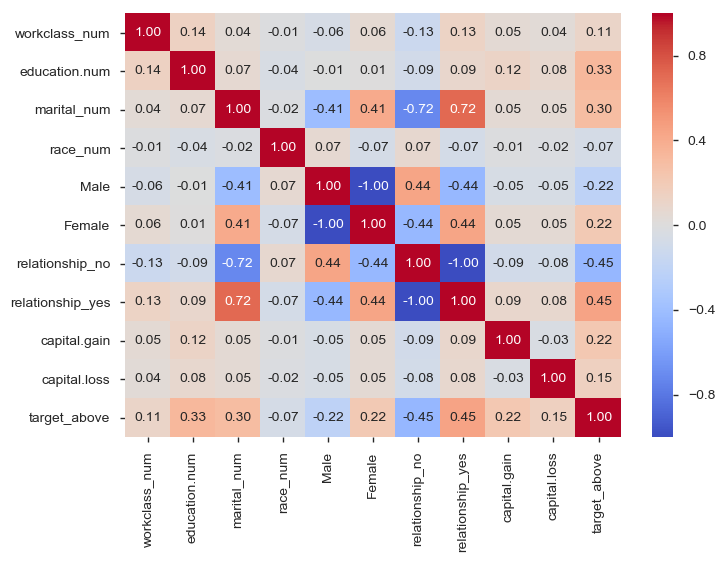

In [17]:
g = sns.heatmap(df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

X_train, X_test, y_train, y_test = split_data(df=df,
                                              keras=False, #Use binary vector for response, no OHE
                                              testSize=0.3,
                                              randomState=123)

#Get Shape of train / test sets.
data = [X_train, X_test, y_train, y_test]
data_list = ["X_train", "X_test", "y_train", "y_test"]
for i in range(4):
    print(data_list[i], "Shape:")
    print(data[i].shape)

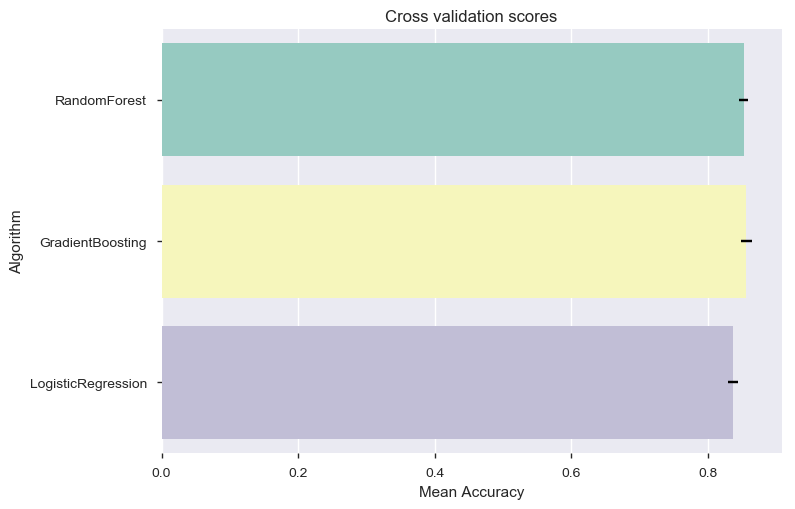

In [18]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5)

#Run Kfold CrossVal on base classifiers

random_state = 1
classifiers = []
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(LogisticRegression(random_state=random_state))

cv_results = []
for classifier in classifiers:
    cv_results.append(
        cross_val_score(classifier,
                        X_train,
                        y=y_train,
                        scoring="accuracy",
                        cv=kfold,
                        n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({
    "CrossValMeans":
    cv_means,
    "CrossValerrors":
    cv_std,
    "Algorithm": ["RandomForest", "GradientBoosting", "LogisticRegression"]
})

g = sns.barplot("CrossValMeans",
                "Algorithm",
                data=cv_res,
                palette="Set3",
                orient="h",
                **{'xerr': cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [19]:
#Grid Search parameter space.

# RFC Parameters tunning
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {
    "n_estimators": [10, 20, 50, 100],
    "max_depth": [None],
    "max_features": [1, 2, 3, 4, 5, 6, 7, 8],
    "min_samples_split": [2, 3, 10, 25, 50],
    "min_samples_leaf": [1, 3, 10],
    #"bootstrap": [False],
    #"n_estimators": [100, 300, 500, 1000],
    "criterion": ["gini"]
}

gsRFC = GridSearchCV(RFC,
                     param_grid=rf_param_grid,
                     cv=kfold,
                     scoring="accuracy",
                     n_jobs=6,
                     verbose=1)
gsRFC.fit(X_train, y_train)

# Gradient boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {
    'loss': ["deviance", "exponential"],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [4, 8],
    'min_samples_leaf': [100, 150],
    'max_features': ["auto", "sqrt", "log2"]
}

gsGBC = GridSearchCV(GBC,
                     param_grid=gb_param_grid,
                     cv=kfold,
                     scoring="accuracy",
                     n_jobs=6,
                     verbose=1)
gsGBC.fit(X_train, y_train)

#Sklearn Logit Regression Tuning
LR = LogisticRegression()
LR_param_grid = {'penalty': ['l1', 'l2']}

gsLR = GridSearchCV(LR,
                    param_grid=LR_param_grid,
                    cv=kfold,
                    scoring="accuracy",
                    n_jobs=6,
                    verbose=1)
gsLR.fit(X_train, y_train)

# Best score
print("\033[1mPrinting Best Cross Validation Accuracy.... \033[0m")
print("RF Best Score: {0:.2f} %".format(gsRFC.best_score_ * 100))
print("GBC Best Score: {0:.2f} %".format(gsGBC.best_score_ * 100))
print("Logit Best Score: {0:.2f} %".format(gsLR.best_score_ * 100))

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    4.1s
[Parallel(n_jobs=6)]: Done 364 tasks      | elapsed:   20.1s
[Parallel(n_jobs=6)]: Done 864 tasks      | elapsed:   49.5s
[Parallel(n_jobs=6)]: Done 1421 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 1871 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 2400 out of 2400 | elapsed:  2.9min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    8.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   50.1s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 1080 out of 1080 | elapsed:  5.2min finished


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Printing Best Cross Validation Accuracy.... 
RF Best Score: 85.62 %
GBC Best Score: 85.95 %
Logit Best Score: 83.79 %


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.1s finished


In [20]:
#Visualizing hyper params of best models + dumping best models to pkl

print("Model Hyper-Parameters:\n")
print(gsRFC.best_estimator_)
print(gsGBC.best_estimator_)
print(gsLR.best_estimator_)

import pickle
from sklearn.externals import joblib

print("Serializing Best Models\n")
rf_file = "models\\UCI_Census\\random_forest.pkl"
joblib.dump(gsRFC.best_estimator_, rf_file)

gbc_file = "models\\UCI_Census\\GBC.pkl"
joblib.dump(gsGBC.best_estimator_, gbc_file)

logit_file = "models\\UCI_Census\\Logit.pkl"
joblib.dump(gsLR.best_estimator_, logit_file)
#Note - Outliers were removed, but no features were scaled / normalized.

Model Hyper-Parameters:

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=150, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Logisti

['models\\UCI_Census\\Logit.pkl']

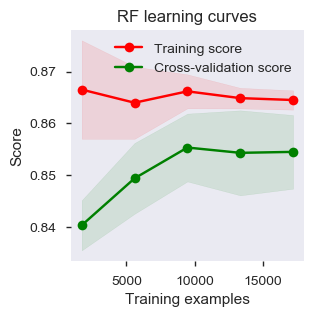

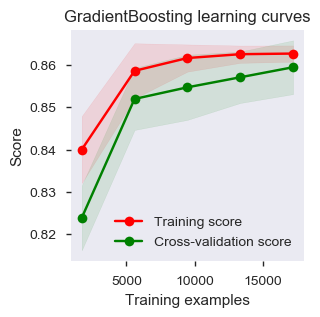

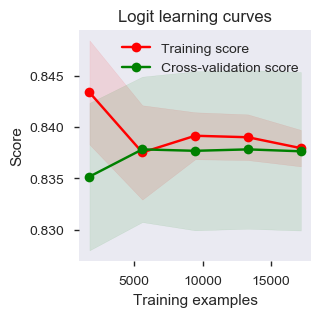

In [21]:
from sklearn.externals import joblib
rcParams['figure.figsize'] = 3, 3  #Adjust plot size
kfold = StratifiedKFold(n_splits=5)
rf_file = "models\\UCI_Census\\random_forest.pkl"
gbc_file = "models\\UCI_Census\\GBC.pkl"
logit_file = "models\\UCI_Census\\Logit.pkl"
#fetch saved models
rfc = joblib.load(rf_file)
gbc = joblib.load(gbc_file)
logit = joblib.load(logit_file)

#Learning Curve. Works better w. more data.
#Visualizes how estimators perform given more data
g = plot_learning_curve(rfc, "RF learning curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(gbc,
                        "GradientBoosting learning curves",
                        X_train,
                        y_train,
                        cv=kfold)
g = plot_learning_curve(logit,
                        "Logit learning curves",
                        X_train,
                        y_train,
                        cv=kfold)

Printing Test Accuracy.... 
Random Forest: 85.41 %
Gradient Boosting: 85.49 %
Logistic Regression: 83.57 % 
 

 Random Forest Classification Report...
 
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      6921
           1       0.78      0.58      0.66      2295

   micro avg       0.85      0.85      0.85      9216
   macro avg       0.82      0.76      0.79      9216
weighted avg       0.85      0.85      0.85      9216



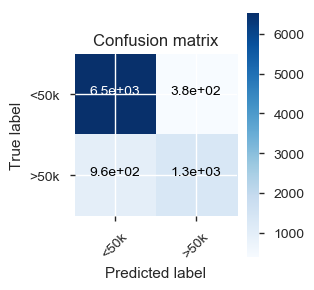

 Gradient Boosting Classification Report...
 
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      6921
           1       0.78      0.58      0.67      2295

   micro avg       0.85      0.85      0.85      9216
   macro avg       0.83      0.76      0.79      9216
weighted avg       0.85      0.85      0.85      9216



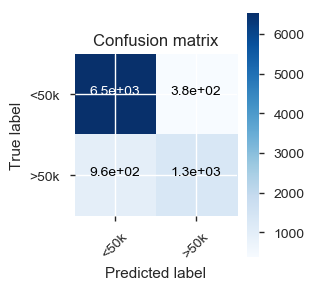

 Logistic Regression Classification Report...
 
              precision    recall  f1-score   support

           0       0.87      0.93      0.89      6921
           1       0.72      0.56      0.63      2295

   micro avg       0.84      0.84      0.84      9216
   macro avg       0.79      0.75      0.76      9216
weighted avg       0.83      0.84      0.83      9216



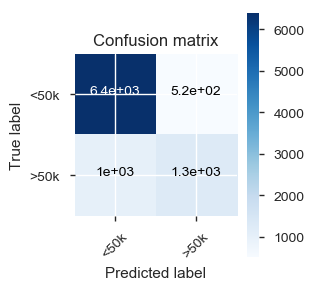

In [22]:
#Some classification Reports and Confusion Matrices
from sklearn.metrics import confusion_matrix, classification_report



#gsRFC.best_estimator_.predict(X_test)
#gsGBC.best_estimator_.predict(X_test)
#gsLR.best_estimator_.predict(X_test)
class_names = ['<50k', '>50k']

rf_best_score = sklearn.metrics.accuracy_score(
    y_test, rfc.predict(X_test))
gbc_best_score = sklearn.metrics.accuracy_score(
    y_test, gbc.predict(X_test))
lr_best_score = sklearn.metrics.accuracy_score(
    y_test, logit.predict(X_test))

print("\033[1mPrinting Test Accuracy.... \033[0m")
print("Random Forest: {0:.2f} %".format(rf_best_score * 100))
print("Gradient Boosting: {0:.2f} %".format(gbc_best_score * 100))
print("Logistic Regression: {0:.2f} % \n \n".format(lr_best_score * 100))

rcParams['figure.figsize'] = 3, 3  #Adjust plot size

print("\033[1m Random Forest Classification Report...\n \033[0m")
print(classification_report(y_test, rfc.predict(X_test)))
cm = confusion_matrix(y_test, rfc.predict(X_test))
plot_confusion_matrix(cm, classes=class_names)
plt.show()

print("\033[1m Gradient Boosting Classification Report...\n \033[0m")
print(classification_report(y_test, gbc.predict(X_test)))
cm = confusion_matrix(y_test, gbc.predict(X_test))
plot_confusion_matrix(cm, classes=class_names)
plt.show()

print("\033[1m Logistic Regression Classification Report...\n \033[0m")
print(classification_report(y_test, logit.predict(X_test)))
cm = confusion_matrix(y_test, logit.predict(X_test))
plot_confusion_matrix(cm, classes=class_names)
plt.show()




### Deep Learning 
Building an MLP. Using Hyperas for hyperparameter search.

- Note that we are scaling a few features here - Logit/GBC/RF were trained w/ no such cleaning.


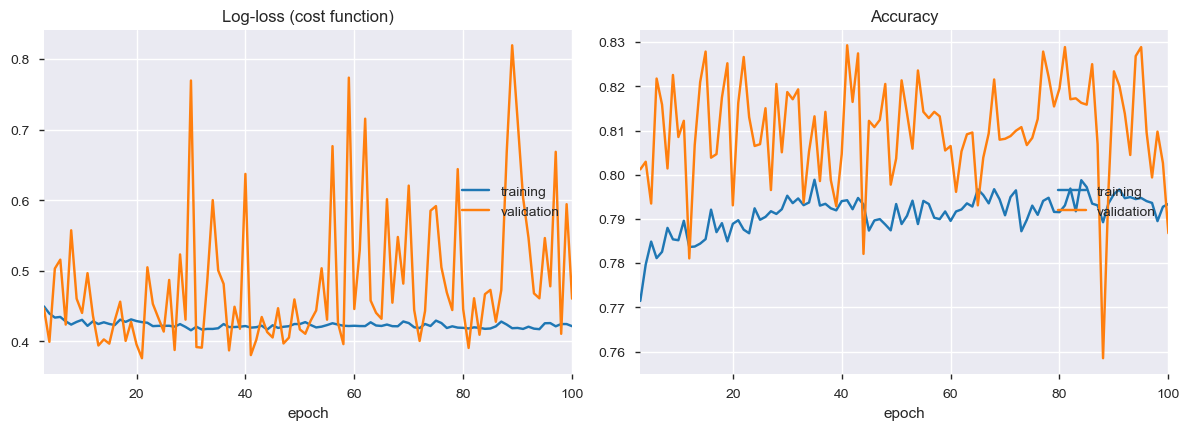

Log-loss (cost function):                                                                                                                                                       
training   (min:    0.416, max:    0.564, cur:    0.422)
validation (min:    0.376, max:    0.820, cur:    0.461)

Accuracy:
training   (min:    0.727, max:    0.799, cur:    0.793)
validation (min:    0.758, max:    0.829, cur:    0.787)
Best validation acc of epoch:                                                                                                                                                   
0.8292980670807684                                                                                                                                                              
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [1:50:22<00:00, 553.10s/it, best loss: -0.8404883013009298]

 
Evalutation of best performing model:
6144/6144 [=

In [38]:
from keras.utils import multi_gpu_model
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform


def data():
    #Use the below three lines for Australian Credit Data
    #df = load_data_gridsearch(
    #    columns=16,  #including index
    #    outlier_columns=['A2', 'A3', 'A13', 'A14'])  # Min Max scaling of features with poisson- like distributions

    df = load_data_UCI()
    X_train, X_test, y_train, y_test = split_data(
        df=df,
        keras=True,  #sets in fp 32 precision with OHE of Response
        testSize=0.2,
        randomState=1)
    return X_train, X_test, y_train, y_test


def create_model(x_train, y_train, x_test, y_test):
    #Keras Callbacks
    #early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
    #                                               min_delta=0,
    #                                               patience=50,
    #                                               verbose=1,
    #                                               mode='auto')
    #MCP = keras.callbacks.ModelCheckpoint("C:\\Users\\jdine\\Documents\\1.MachineLearning\\hicss2020-master\\model_weights\\best_model.h5",
    #                                      monitor='val_loss', mode='min', verbose=1, save_best_only= True)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=3,
                                                  min_lr=0.001)  #Annealing.
    #tensorboard = keras.callbacks.TensorBoard(
    #    log_dir="logs\\")

    model = Sequential()
    model.add(Dense(
        {{choice([32, 64, 128])}},
        input_shape=(8, )))  #Input shape = input Dim = Number of Ind Vars
    model.add(
        Activation({{choice(['relu', 'sigmoid', 'tanh', 'elu', 'selu'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(BatchNormalization(momentum={{uniform(0, 1)}}))
    model.add(Dense({{choice([32, 64, 128])}}))
    model.add(
        Activation({{choice(['relu', 'sigmoid', 'tanh', 'elu', 'selu'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(BatchNormalization(momentum={{uniform(0, 1)}}))

    # If we choose 'four', add an additional fourth layer
    if {{choice(['three', 'four'])}} == 'four':
        model.add(Dense({{choice([32, 64, 128])}}))
        model.add(Activation({{choice(['relu', 'sigmoid', 'tanh'])}}))
        model.add(Dropout({{uniform(0, 1)}}))
        model.add(BatchNormalization(momentum={{uniform(0, 1)}}))


    model.add(Dense(2))
    model.add(Activation('sigmoid'))
    model = multi_gpu_model(model, gpus=2)
    model.compile(
        loss='binary_crossentropy',
        optimizer={{
            choice([
                'rmsprop', 'adam'
                #, 'sgd', 'adagrad', 'adadelta',
                #'adamax', 'nadam'
            ])
        }},
        metrics=['accuracy'])
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                            log_device_placement=True))
    result = model.fit(X_train, y_train, batch_size= {{choice([32,64, 128])}},
                       epochs={{choice([100])}}, verbose=2,\
                            validation_split= .20, callbacks=[PlotLossesKeras(), reduce_lr])

    #get the highest validation accuracy of the training epochs
    validation_acc = np.amax(result.history['val_acc'])
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}


best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=15,
                                      trials=Trials(),
                                      notebook_name='model_train',
                                      eval_space=True)

X_train, X_test, y_train, y_test = data()
print("\n \nEvalutation of best performing model:")
print(best_model.evaluate(X_test, y_test))
print("\n \nBest performing model chosen hyper-parameters:")
print(best_run)

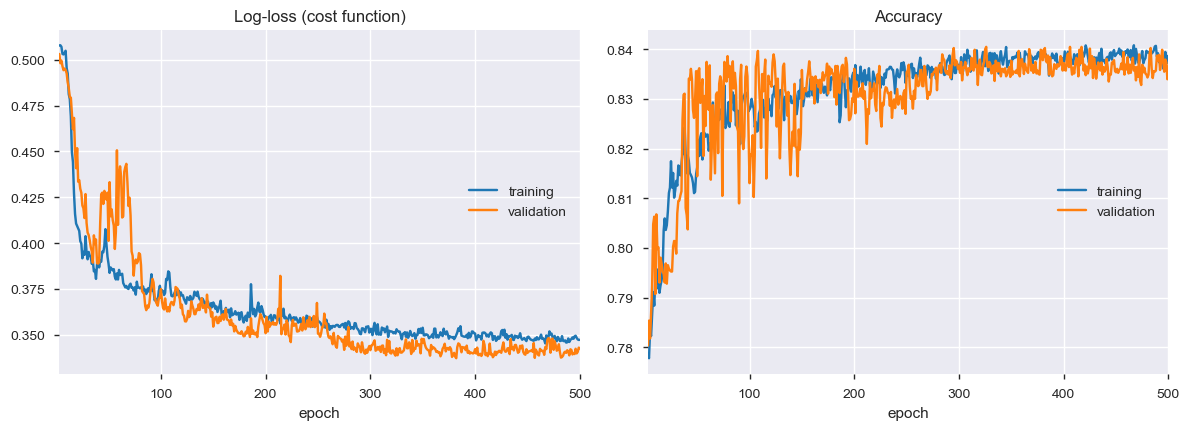

Log-loss (cost function):
training   (min:    0.345, max:    0.617, cur:    0.347)
validation (min:    0.337, max:    0.504, cur:    0.343)

Accuracy:
training   (min:    0.704, max:    0.841, cur:    0.838)
validation (min:    0.779, max:    0.841, cur:    0.837)

Epoch 00500: val_acc did not improve from 0.84050


In [23]:
#Keras Callbacks
#early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
#                                               min_delta=0,
#                                               patience=50,
#                                               verbose=1,
#                                               mode='auto')

X_train, X_test, y_train, y_test = split_data(
    df=df,
    keras=True,  #Use binary vector for response, no OHE
    testSize=0.3,
    randomState=123)

MCP = keras.callbacks.ModelCheckpoint(
    "C:\\Users\\jdine\\Documents\\1.MachineLearning\\hicss2020-master\\models\\UCI_Census\\ann_gridsearch.h5",
    monitor='val_acc',
    mode='max',
    verbose=1,
    save_best_only=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              factor=0.1,
                                              patience=10,
                                              min_lr=0.01)  #Annealing.
tensorboard = keras.callbacks.TensorBoard(log_dir="logs\\")

model = Sequential()
model.add(Dense(
    500, input_shape=(10, )))  #Input shape = input Dim = Number of Ind Vars
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(.5))

#model.add(BatchNormalization())
model.add(Dense(256))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(.5))

model.add(Dense(128))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(.5))


model.add(Dense(32))
model.add(Activation('relu'))
#model.add(Dropout(.5))
#model.add(BatchNormalization())

model.add(Dense(2))
model.add(Activation('sigmoid'))

model = multi_gpu_model(model, gpus=2)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                        log_device_placement=True))

result = model.fit(X_train, y_train, batch_size= 2048,
                   epochs=500, verbose=2,\
                        validation_split= .20, callbacks=[PlotLossesKeras(), reduce_lr, MCP, tensorboard])

In [24]:
path_to_ann = 'models\\UCI_Census\\ann_gridsearch.h5'
#model.save(path_to_ann)

In [25]:
model = load_model(path_to_ann)

 Neural Net Classification Report...
 
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      6933
           1       0.75      0.53      0.62      2283

   micro avg       0.84      0.84      0.84      9216
   macro avg       0.80      0.73      0.76      9216
weighted avg       0.83      0.84      0.83      9216



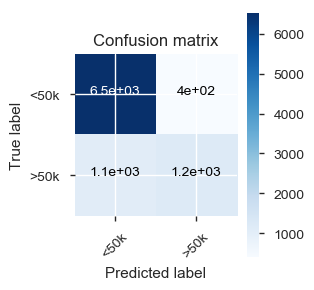

0.8390842013888888

In [26]:
#Some classification Reports and Confusion Matrices
ypred = np.argmax(model.predict(X_test), axis = 1)
ytest = np.argmax(y_test, axis = 1)

print("\033[1m Neural Net Classification Report...\n \033[0m")
print(classification_report(ytest, np.argmax(model.predict(X_test), axis = 1)))
cm = confusion_matrix(ytest, np.argmax(model.predict(X_test), axis = 1))
plot_confusion_matrix(cm, classes=class_names)
plt.show()
sklearn.metrics.accuracy_score(ytest,ypred)

## Explainability

### Basic Sklearn Model Interpretability Functionality

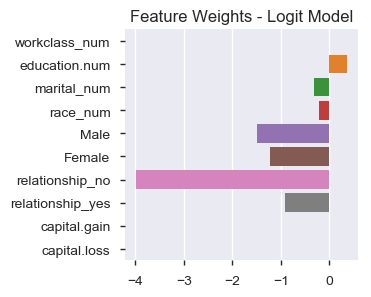

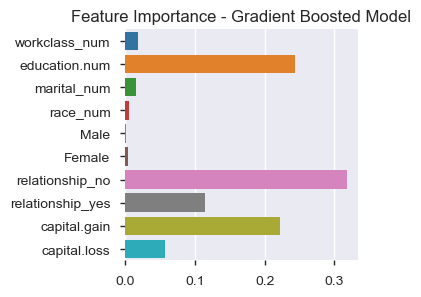

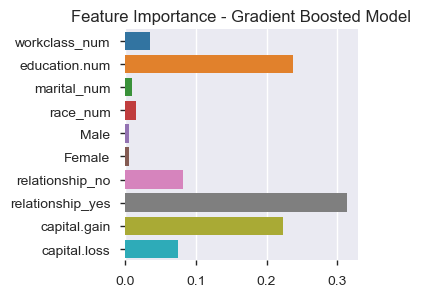

In [99]:
'''

data['workclass_num'] = data.workclass.map({'Private':0, 'State-gov':1, 'Federal-gov':2, 'Self-emp-not-inc':3, 'Self-emp-inc':4, 'Local-gov':5, 'Without-pay':6})
data['marital_num'] = data['marital.status'].map({'Widowed':0, 'Divorced':1, 'Separated':2, 'Never-married':3, 'Married-civ-spouse':4, 'Married-AF-spouse':4, 'Married-spouse-absent':5})
data['race_num'] = data.race.map({'White':0, 'Black':1, 'Asian-Pac-Islander':2, 'Amer-Indian-Eskimo':3, 'Other':4})
data['sex_num'] = np.where(data.sex == 'Female', 0, 1)
data['relative_num'] = data.relationship.map({'Not-in-family':0, 'Unmarried':0, 'Own-child':0, 'Other-relative':0, 'Husband':1, 'Wife':1})

'''
a = list(logit.coef_[0])
cols = list(df.columns[:-1])
logit_weights = dict(zip(b,a))

sns.barplot(a,cols)
plt.title('Feature Weights - Logit Model')
plt.show()


b = gbc.feature_importances_
sns.barplot(b,cols)
plt.title('Feature Importance - Gradient Boosted Model')
plt.show()

c = rfc.feature_importances_
sns.barplot(c,cols)
plt.title('Feature Importance - Gradient Boosted Model')
plt.show()



In [3]:
!pip install lime

import lime

import lime.lime_tabular

